In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import math
from marswinds.utils import radian_to_degree, degree_to_radian
from tensorflow.keras.models import load_model
import joblib
from os import listdir
from os.path import isfile, join

In [41]:
dune_test_path = '../raw_data/images/testing/dunes'
no_dune_test_path = '../raw_data/images/testing/no_dunes'
base_folder='../raw_data/trained_models'

regressor = load_model(f'{base_folder}/regressor.h5')
classifier = load_model(f'{base_folder}/classifier.h5')
scaler = joblib.load(f'{base_folder}/scaler.lib')

/Users/cedric/.pyenv/versions/marswinds/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Testing the regressor

In [4]:
test_files = [f for f in listdir(dune_test_path) if len(f)>30]
test_files

['21.26750068664551_49.7474983215332_021_CW000_-0.46574658155441284_-0.7453307509422302_2.059357166290283.jpg',
 '25.687500762939454_27.047500228881837_023_CW000_-0.9113928079605103_0.05076518654823303_2.305976629257202.jpg',
 '17.957499313354493_45.307499694824216_021_CW000_-0.18906854093074799_-0.7375072240829468_2.087489366531372.jpg',
 '21.942499542236327_51.14749984741211_031_CW000_-0.6997101306915283_-0.5268574953079224_1.9518530368804932.jpg',
 '19.237500762939455_47.067501831054685_01_CW000_-0.20449663698673248_-0.8018671870231628_2.1900315284729004.jpg',
 '19.16250076293945_46.14250030517578_030_CW000_-0.05183742940425873_-0.7814042568206787_2.3391456604003906.jpg',
 '17.457499313354493_45.88249816894531_020_CW000_-0.29441502690315247_-0.7210420966148376_1.8764872550964355.jpg',
 '19.087500381469727_47.09250183105469_022_CW000_-0.2237136960029602_-0.7975105047225952_2.185014247894287.jpg',
 '26.167500305175782_23.10250015258789_022_CW000_-0.5812627673149109_-0.5440924763679504

In [5]:
def get_label(image_name):
    parts = image_name[:-4].split('_')
    sin = float(parts[-3])
    cos = float(parts[-2])
    angle = radian_to_degree(math.atan2(sin, cos))
    wind_strength = float(parts[-1])
    
    return(wind_strength, angle)

In [6]:
labels = [get_label(f) for f in test_files]
labels

[(2.059357166290283, -147.999323401774),
 (2.305976629257202, -86.81188130312769),
 (2.087489366531372, -165.62122061312337),
 (1.9518530368804932, -126.97848088751468),
 (2.1900315284729004, -165.69307252037078),
 (2.3391456604003906, -176.20462719261215),
 (1.8764872550964355, -157.7888841562634),
 (2.185014247894287, -164.3303926190748),
 (2.088409185409546, -133.1082179752102),
 (1.9987354278564453, -130.46405805753315),
 (1.9943571090698242, -148.3305820868745),
 (1.9866714477539062, -125.87920542947336),
 (1.9017021656036377, -116.61542870522194),
 (1.8634003400802612, -100.96734666080566),
 (2.270188093185425, 178.9280647700407),
 (2.2007901668548584, 172.54037092706173),
 (1.8151183128356934, -110.72676325609417),
 (2.2780473232269287, -175.60078899575754),
 (1.9031673669815063, -107.32957790910199),
 (1.9228026866912842, -142.98260697486262),
 (2.2173662185668945, 172.14937831978872),
 (2.0700831413269043, -144.02199776361354),
 (1.9671698808670044, -126.55661900471978),
 (1.7

In [7]:
def prediction_from_models(image_name):
        image_path = f'{dune_test_path}/{image_name}'
        try:
            image = cv2.imread(image_path)
            grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0
            expanded = np.expand_dims(np.expand_dims(grey_image,axis=0), axis=3)
            predicted_regressed = regressor.predict(expanded)[0]
            wind_strength = predicted_regressed[0]
            sin = predicted_regressed[1] # Changed to match Aris code
            cos = predicted_regressed[0]
            angle_rad = math.atan2(sin, cos)
        except:
            print(f'Problem with file {image_path}')
            return (np.nan,np.nan)
        
        return (scaler.inverse_transform([[wind_strength]])[0][0], radian_to_degree(angle_rad))

In [8]:
log_name = '../raw_data/logs/testing_regressor.csv'
d = {'filename':[],
    'angular_diff':[],
    'speed_diff':[],
    'predicted_angle':[],
    'actual_angle':[]}

df = pd.DataFrame.from_dict(d).to_csv(log_name, index=False)

def get_diff(files):
    
    for file in files:
        pred_wind, pred_angle = prediction_from_models(file)
        label_wind, label_angle = get_label(file)
        
        wind_diff = np.abs(label_wind-pred_wind)
        angle_diff = np.abs(label_angle-pred_angle)
        if angle_diff > 180: angle_diff = 360-angle_diff
            
        d = {'filename':[file],
        'angular_diff':[angle_diff**2],
        'speed_diff':[wind_diff**2],
    'predicted_angle':[pred_angle],
    'actual_angle':[label_angle]}

        pd.concat([pd.read_csv(log_name), pd.DataFrame.from_dict(d)]).to_csv(log_name, index=False)
    
    return pd.read_csv(log_name)
        
        

In [9]:
get_diff(test_files)


,filename,angular_diff,speed_diff,predicted_angle,actual_angle
0,21.26750068664551_49.7474983215332_021_CW000_-...,8955.047140,0.001001,-53.368213,-147.999323
1,25.687500762939454_27.047500228881837_023_CW00...,7302.174913,0.070449,-1.359117,-86.811881
2,17.957499313354493_45.307499694824216_021_CW00...,28115.936531,0.000148,2.056853,-165.621221
3,21.942499542236327_51.14749984741211_031_CW000...,16342.395293,0.082138,0.858897,-126.978481
4,19.237500762939455_47.067501831054685_01_CW000...,13079.594750,0.003397,-51.327017,-165.693073
...,...,...,...,...,...
13956,22.117499923706056_49.34750061035156_01_CW000_...,20032.583264,0.072859,1.937056,-139.599453
13957,20.867499160766602_51.022501373291014_020_CW00...,10268.336193,0.028949,-37.132040,-138.464839
13958,18.937499618530275_46.26749877929687_01_CW000_...,15569.567566,0.109537,-46.042855,-170.820928
13959,26.3424991607666_22.802500915527343_032_CW000_...,14737.902570,0.036431,-9.332630,-130.732393


In [10]:
res = pd.read_csv(log_name)

np.sqrt(res.angular_diff.mean())

127.58732673256958

In [14]:
bad_res = res[res.angular_diff>100**2]

In [15]:
bad_res.drop_duplicates()

,filename,angular_diff,speed_diff,predicted_angle,actual_angle
2,17.957499313354493_45.307499694824216_021_CW00...,28115.936531,0.000148,2.056853,-165.621221
3,21.942499542236327_51.14749984741211_031_CW000...,16342.395293,0.082138,0.858897,-126.978481
4,19.237500762939455_47.067501831054685_01_CW000...,13079.594750,0.003397,-51.327017,-165.693073
5,19.16250076293945_46.14250030517578_030_CW000_...,19686.067005,0.075028,-35.897582,-176.204627
6,17.457499313354493_45.88249816894531_020_CW000...,27125.189693,0.136979,6.908383,-157.788884
...,...,...,...,...,...
13956,22.117499923706056_49.34750061035156_01_CW000_...,20032.583264,0.072859,1.937056,-139.599453
13957,20.867499160766602_51.022501373291014_020_CW00...,10268.336193,0.028949,-37.132040,-138.464839
13958,18.937499618530275_46.26749877929687_01_CW000_...,15569.567566,0.109537,-46.042855,-170.820928
13959,26.3424991607666_22.802500915527343_032_CW000_...,14737.902570,0.036431,-9.332630,-130.732393


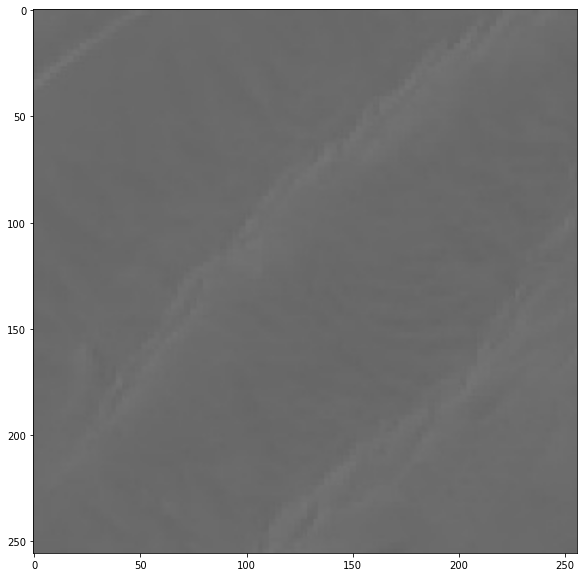

In [16]:
image_path = f'{dune_test_path}/{bad_res.loc[6,"filename"]}'

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(cv2.imread(image_path), cmap='Greys')

In [17]:
np.sqrt(res.angular_diff.mean())

127.58732673256958

In [23]:
mrse_wind_model = np.sqrt(res.speed_diff.mean())

<AxesSubplot:>

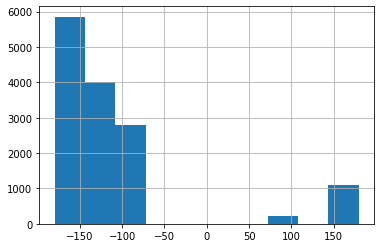

In [19]:
res.actual_angle.hist()

<AxesSubplot:>

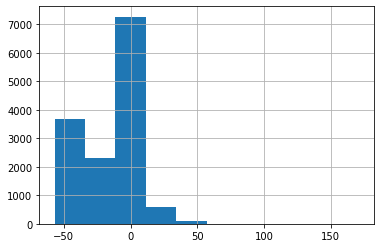

In [20]:
res.predicted_angle.hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

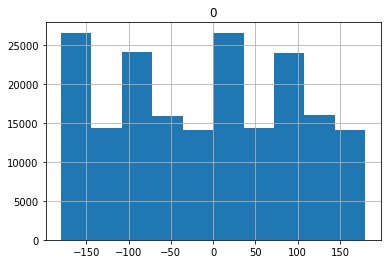

In [25]:
dune_train_path = '../raw_data/images/training/dunes'
train_files = [f for f in listdir(dune_train_path) if len(f)>30]
train_labels_direction = [get_label(f)[1] for f in train_files]
pd.DataFrame(train_labels_direction).hist()

### Performance of wind direction prediction model

In [27]:
mean_wind_dir = np.mean(train_labels_direction)
mrse_base_wind_dir = np.sqrt(np.mean((np.array(train_labels_direction)-mean_wind_dir)**2))
mrse_model_wind_dir = np.sqrt(res.angular_diff.mean())

print(f'MRSE our model: {mrse_model_wind_dir}')
print(f'MRSE base prediction: {mrse_base_wind_dir}')

MRSE our model: 127.58732673256958
MRSE base prediction: 104.09537855498087


### Performance of wind strength prediction model

In [22]:
wind_directions_training = [get_label(f)[0] for f in train_files]

mean_wind_direction = np.mean(wind_directions_training)

base_model_score = np.sqrt(np.mean((np.array(wind_directions_training)-mean_wind_direction)**2))
base_model_score

0.36327340002751357

In [24]:
print(f'MRSE our model: {mrse_wind_model}')
print(f'MRSE base prediction: {base_model_score}')

MRSE our model: 0.34568669380720196
MRSE base prediction: 0.36327340002751357


# Testing the Classifier

In [60]:
def prediction_from_classifier(image_name):
        image_path = f'{dune_test_path}/{image_name}'
        try:
            image = cv2.imread(image_path)
            grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) / 255.0
            expanded = np.expand_dims(np.expand_dims(grey_image,axis=0), axis=3)
            predicted_proba = classifier.predict(expanded)[0][0]
            if predicted_proba > 0.5:
                predicted_class = 'dunes'
            else:
                predicted_class = 'no_dunes'
        except:
            print(f'Problem with file {image_path}')
            return (np.nan,np.nan)
        
        return (predicted_proba, predicted_class)

In [62]:
log_name = '../raw_data/logs/testing_classifier2.csv'
d = {'filename':[],
    'actual_class':[],
    'predicted_class':[],
    'predicted_proba':[]}

df = pd.DataFrame.from_dict(d).to_csv(log_name, index=False)

def get_class(files, label):
    
    for file in files:
        pred_proba, pred_class = prediction_from_classifier(file)

            
        d = {'filename':[file],
        'actual_class':[label],
        'predicted_class':[pred_class],
        'predicted_proba':[pred_proba]}

        pd.concat([pd.read_csv(log_name), pd.DataFrame.from_dict(d)]).to_csv(log_name, index=False)
    
    return pd.read_csv(log_name)

In [65]:
dune_test_path = '../raw_data/images/testing/dunes'
no_dune_test_path = '../raw_data/images/testing/no_dunes'

is_dune_files = ('dunes', [f for f in listdir(dune_test_path) if len(f)>30])
no_dune_files = ('no_dunes',[f for f in listdir(no_dune_test_path) if len(f)>30])

In [ ]:
log_name = '../raw_data/logs/testing_classifier.csv'

for files in [is_dune_files,no_dune_files]:
    get_class(files[1], files[0])


In [50]:
results = pd.read_csv(log_name)